In [79]:
import tensorflow as tf

In [80]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [81]:
import pandas as pd
time_data = pd.read_csv(r'../Dataset/2nd_Wave_Dataset.csv', header=None)

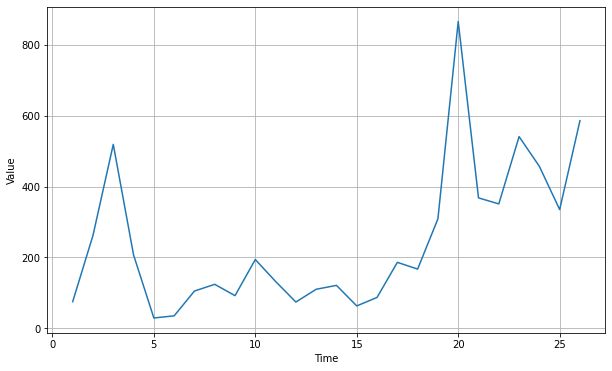

In [89]:
import csv
time_step = []
covid = []
step = 1

with open(r'../Dataset/2nd_Wave_dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        covid.append(float(row[1]))
        time_step.append(step)
        step += 1
        
series = np.array(covid)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [90]:
len(series)

26

In [91]:
split_time = 22
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 22
shuffle_buffer_size = 20

In [92]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [93]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = window_size
batch_size = batch_size
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(20, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(22,)
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 4ms/step - loss: 218.6411 - mae: 219.1411
Epoch 2/100
1/1 [==============================] - 0s 958us/step - loss: 218.6179 - mae: 219.1179
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 218.5732 - mae: 219.0732
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 218.5084 - mae: 219.0084
Epoch 5/100
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 119.4001 - mae: 119.8865
Epoch 77/100
1/1 [==============================] - 0s 985us/step - loss: 119.3099 - mae: 119.8099
Epoch 78/100
1/1 [==============================] - 0s 807us/step - loss: 119.2135 - mae: 119.7135
Epoch 79/100
1/1 [==============================] - 0s 836us/step - loss: 119.0993 - mae: 119.5993
Epoch 80/100
1/1 [==============================] - 0s 997us/step - loss: 118.9504 - mae: 119.4504
Epoch 81/100
1/1 [==============================] - 0s 1ms/step - loss: 118.7664 - mae: 119.2664
Epoch 82/100
1/1 [==============================] - 0s 932us/step - loss: 118.6345 - mae: 119.1258
Epoch 83/100
1/1 [==============================] - 0s 1ms/step - loss: 118.5250 - mae: 119.0250
Epoch 84/100
1/1 [==============================] - 0s 948us/step - loss: 118.6661 - mae: 119.1661
Epoch 85/100
1/1 [==============================] - 0s 944us/step - loss: 124.2530 - mae: 124.7530
Epoch 86/100
1/1 [===========

(1e-08, 0.0001, 0.0, 1000.0)

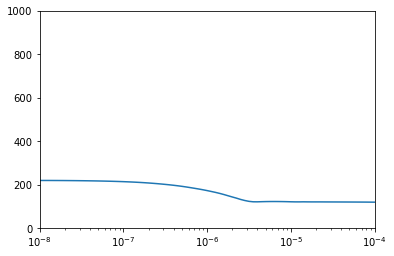

In [98]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])

In [223]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=7, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(44, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(22, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(11, return_sequences=True)),
  #tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(30, activation="tanh"),
  tf.keras.layers.Dense(15, activation="tanh"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 5ms/step - loss: 169.5548 - mae: 170.0548
Epoch 2/500
1/1 [==============================] - 0s 838us/step - loss: 250.2306 - mae: 250.7306
Epoch 3/500
1/1 [==============================] - 0s 844us/step - loss: 210.8865 - mae: 211.3856
Epoch 4/500
1/1 [==============================] - 0s 777us/step - loss: 195.4314 - mae: 195.9314
Epoch 5/500
1/1 [==============================] - 0s 790us/step - loss: 113.6673 - mae: 114.1673
Epoch 6/500
1/1 [==============================] - 0s 827us/step - loss: 186.6330 - mae: 187.1330
Epoch 7/500
1/1 [==============================] - 0s 802us/step - loss: 109.0209 - mae: 109.5209
Epoch 8/500
1/1 [==============================] - 0s 880us/step - loss: 139.2402 - mae: 139.7402
Epoch 9/500
1/1 [==============================] - 0s 821us/step - loss: 110.5002 - mae: 111.0002
Epoch 10/500
1/1 [==============================] - 0s 960us/step - loss: 133.5257 - mae: 134.0257
Epoch 11/500
1/1 [===

1/1 [==============================] - 0s 792us/step - loss: 77.7793 - mae: 78.2793
Epoch 86/500
1/1 [==============================] - 0s 798us/step - loss: 53.6037 - mae: 54.0909
Epoch 87/500
1/1 [==============================] - 0s 749us/step - loss: 71.7146 - mae: 72.2146
Epoch 88/500
1/1 [==============================] - 0s 774us/step - loss: 57.1816 - mae: 57.6816
Epoch 89/500
1/1 [==============================] - 0s 812us/step - loss: 55.4053 - mae: 55.8956
Epoch 90/500
1/1 [==============================] - 0s 892us/step - loss: 66.9839 - mae: 67.4839
Epoch 91/500
1/1 [==============================] - 0s 860us/step - loss: 48.9328 - mae: 49.4328
Epoch 92/500
1/1 [==============================] - 0s 801us/step - loss: 60.1536 - mae: 60.6536
Epoch 93/500
1/1 [==============================] - 0s 783us/step - loss: 66.5265 - mae: 67.0265
Epoch 94/500
1/1 [==============================] - 0s 943us/step - loss: 53.1444 - mae: 53.6441
Epoch 95/500
1/1 [=========================

1/1 [==============================] - 0s 898us/step - loss: 45.1845 - mae: 45.6845
Epoch 169/500
1/1 [==============================] - 0s 797us/step - loss: 45.4915 - mae: 45.9791
Epoch 170/500
1/1 [==============================] - 0s 788us/step - loss: 49.9007 - mae: 50.4007
Epoch 171/500
1/1 [==============================] - 0s 758us/step - loss: 45.7860 - mae: 46.2860
Epoch 172/500
1/1 [==============================] - 0s 841us/step - loss: 45.3384 - mae: 45.8378
Epoch 173/500
1/1 [==============================] - 0s 795us/step - loss: 49.4341 - mae: 49.9313
Epoch 174/500
1/1 [==============================] - 0s 815us/step - loss: 56.9576 - mae: 57.4576
Epoch 175/500
1/1 [==============================] - 0s 782us/step - loss: 65.3112 - mae: 65.8106
Epoch 176/500
1/1 [==============================] - 0s 774us/step - loss: 45.1518 - mae: 45.6507
Epoch 177/500
1/1 [==============================] - 0s 802us/step - loss: 42.2528 - mae: 42.7453
Epoch 178/500
1/1 [===============

1/1 [==============================] - 0s 914us/step - loss: 69.3383 - mae: 69.8383
Epoch 252/500
1/1 [==============================] - 0s 936us/step - loss: 68.9570 - mae: 69.4570
Epoch 253/500
1/1 [==============================] - 0s 787us/step - loss: 28.1146 - mae: 28.6146
Epoch 254/500
1/1 [==============================] - 0s 776us/step - loss: 67.2014 - mae: 67.7014
Epoch 255/500
1/1 [==============================] - 0s 780us/step - loss: 39.2891 - mae: 39.7891
Epoch 256/500
1/1 [==============================] - 0s 877us/step - loss: 52.8640 - mae: 53.3640
Epoch 257/500
1/1 [==============================] - 0s 915us/step - loss: 50.2180 - mae: 50.7180
Epoch 258/500
1/1 [==============================] - 0s 823us/step - loss: 36.2378 - mae: 36.7378
Epoch 259/500
1/1 [==============================] - 0s 863us/step - loss: 30.5800 - mae: 31.0786
Epoch 260/500
1/1 [==============================] - 0s 883us/step - loss: 32.4112 - mae: 32.9112
Epoch 261/500
1/1 [===============

1/1 [==============================] - 0s 849us/step - loss: 29.9198 - mae: 30.4027
Epoch 335/500
1/1 [==============================] - 0s 792us/step - loss: 29.8682 - mae: 30.3563
Epoch 336/500
1/1 [==============================] - 0s 833us/step - loss: 27.2389 - mae: 27.7389
Epoch 337/500
1/1 [==============================] - 0s 797us/step - loss: 19.3027 - mae: 19.8026
Epoch 338/500
1/1 [==============================] - 0s 820us/step - loss: 21.9521 - mae: 22.4521
Epoch 339/500
1/1 [==============================] - 0s 818us/step - loss: 14.1525 - mae: 14.6525
Epoch 340/500
1/1 [==============================] - 0s 784us/step - loss: 36.2553 - mae: 36.7553
Epoch 341/500
1/1 [==============================] - 0s 780us/step - loss: 19.4298 - mae: 19.9298
Epoch 342/500
1/1 [==============================] - 0s 775us/step - loss: 43.5326 - mae: 44.0326
Epoch 343/500
1/1 [==============================] - 0s 838us/step - loss: 35.2436 - mae: 35.7436
Epoch 344/500
1/1 [===============

1/1 [==============================] - 0s 965us/step - loss: 61.6685 - mae: 62.1685
Epoch 418/500
1/1 [==============================] - 0s 829us/step - loss: 25.2562 - mae: 25.7562
Epoch 419/500
1/1 [==============================] - 0s 859us/step - loss: 59.9600 - mae: 60.4600
Epoch 420/500
1/1 [==============================] - 0s 789us/step - loss: 75.3418 - mae: 75.8418
Epoch 421/500
1/1 [==============================] - 0s 777us/step - loss: 41.0910 - mae: 41.5910
Epoch 422/500
1/1 [==============================] - 0s 787us/step - loss: 51.6290 - mae: 52.1290
Epoch 423/500
1/1 [==============================] - 0s 822us/step - loss: 74.7459 - mae: 75.2459
Epoch 424/500
1/1 [==============================] - 0s 788us/step - loss: 46.9701 - mae: 47.4701
Epoch 425/500
1/1 [==============================] - 0s 762us/step - loss: 28.5693 - mae: 29.0670
Epoch 426/500
1/1 [==============================] - 0s 760us/step - loss: 47.5743 - mae: 48.0743
Epoch 427/500
1/1 [===============

In [224]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

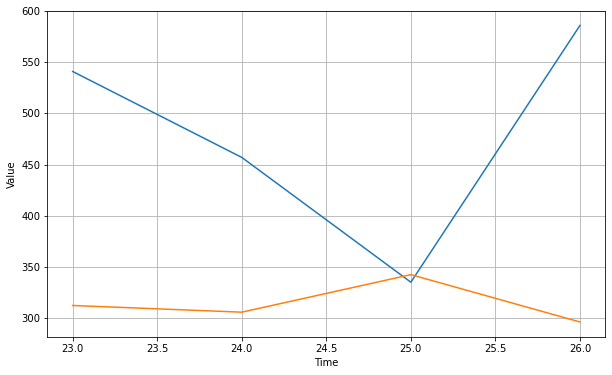

In [225]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [226]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

array([167.51556, 174.05286, 141.06274, 183.63889], dtype=float32)

<Figure size 432x288 with 0 Axes>

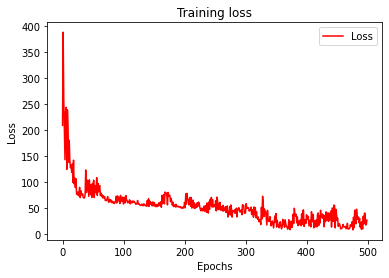

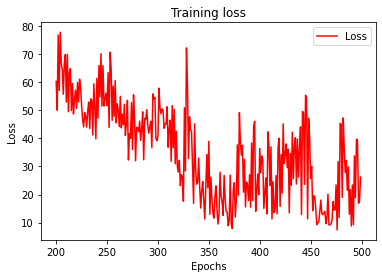

<Figure size 432x288 with 0 Axes>

In [194]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [195]:
print(rnn_forecast)

[115.74751 448.19003 342.12772 155.0791 ]


In [196]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 7)           28        
_________________________________________________________________
bidirectional (Bidirectional (None, None, 80)          11760     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 60)          20160     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 40)          9840      
_________________________________________________________________
dense (Dense)                (None, None, 35)          1435      
_________________________________________________________________
dense_1 (Dense)              (None, None, 22)          792       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           2